# Notebook: 04 - Dataset EDA

**Purpose:** Exploratory Data Analysis for `urdu_stories_final_preprocessed.json` and `urdu_tokenizer_training.txt`.

Objectives: dataset counts, length distributions, special-token inventory, terminator/script checks, flagged examples, and summary preparation.

In [9]:
# Imports & helpers
import json, re, statistics
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path.cwd()
ROOT = NOTEBOOK_DIR.parent
DATA_JSON = ROOT / 'urdu_stories_final_preprocessed.json'
if not DATA_JSON.exists():
    raise FileNotFoundError(f"{DATA_JSON} not found — run preprocessing/01-cleaning.ipynb to create it")
TRAIN_TXT = ROOT / 'urdu_tokenizer_training.txt'

In [10]:
# Load data

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_txt_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [ln.strip() for ln in f if ln.strip()]

stories = []
tok_lines = []
if DATA_JSON.exists():
    stories = load_json(DATA_JSON)
    print(f'Loaded {len(stories)} stories from {DATA_JSON.name}')
else:
    print(f'WARNING: {DATA_JSON} not found')

if TRAIN_TXT.exists():
    tok_lines = load_txt_lines(TRAIN_TXT)
    print(f'Loaded {len(tok_lines)} lines from {TRAIN_TXT.name}')
else:
    print(f'WARNING: {TRAIN_TXT} not found')

Loaded 287 stories from urdu_stories_final_preprocessed.json
Loaded 287 lines from urdu_tokenizer_training.txt


In [ ]:
# Basic counts & duplicates
story_count = len(stories)
titles = [s.get('urdu_title','').strip() for s in stories]
duplicate_titles = [t for t,c in Counter(titles).items() if c>1]
empty_stories = [i for i,s in enumerate(stories) if not s.get('content','').strip()]

print('story_count=', story_count)
print('duplicates=', len(duplicate_titles))
print('empty entries=', len(empty_stories))

story_count= 287
duplicates= 3 sample= ['دوست وہ جو مصیبت میں کام آئے', 'احساس', 'صبر کا انعام']
empty entries= 0


chars: {'min': 1021, 'median': 2911, 'mean': 3349.034843205575, 'p90': 5859, 'max': 10522}
words: {'min': 224, 'median': 640, 'mean': 736.4912891986063, 'p90': 1300, 'max': 2352}


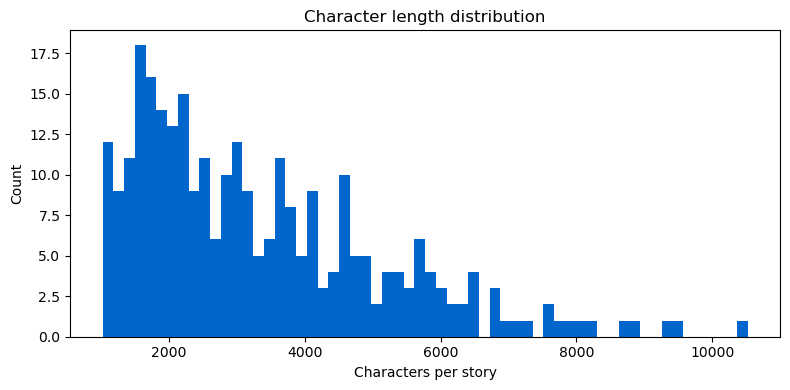

In [4]:
# Length statistics (characters & words)
char_lens = [len(s.get('content','')) for s in stories]
word_lens = [len(re.findall(r"\S+", s.get('content',''))) for s in stories]

def stats(arr):
    if not arr:
        return {'min':0,'median':0,'mean':0,'p90':0,'max':0}
    return {
        'min': min(arr),
        'median': statistics.median(arr),
        'mean': statistics.mean(arr),
        'p90': (sorted(arr)[int(0.9*len(arr))]) if len(arr)>0 else 0,
        'max': max(arr)
    }

print('chars:', stats(char_lens))
print('words:', stats(word_lens))

# histogram
plt.figure(figsize=(8,4))
plt.hist(char_lens, bins=60, color='#0066CC')
plt.xlabel('Characters per story')
plt.ylabel('Count')
plt.title('Character length distribution')
plt.tight_layout()
plt.show()

In [5]:
# Marker inventory and paragraph counts

def count_markers(text):
    return {tok: text.count(tok) for tok in ['<EOS>','<EOP>','<EOT>']}

marker_counts = [count_markers(s.get('content','')) for s in stories]
total_marker = Counter()
for mc in marker_counts:
    total_marker.update(mc)

print('Total markers (sum over stories):', dict(total_marker))
# fraction missing <EOT>
missing_eot = sum(1 for s in stories if '<EOT>' not in s.get('content',''))
print('stories missing <EOT>:', missing_eot, '/', len(stories))

# paragraphs per story (approx)
eop_counts = [mc['<EOP>'] for mc in marker_counts]
print('paragraphs per story — mean/median/max:', statistics.mean(eop_counts) if eop_counts else 0, statistics.median(eop_counts) if eop_counts else 0, max(eop_counts) if eop_counts else 0)

Total markers (sum over stories): {'<EOS>': 13730, '<EOP>': 4250, '<EOT>': 287}
stories missing <EOT>: 0 / 287
paragraphs per story — mean/median/max: 14.80836236933798 11 79


In [6]:
# Terminators and script checks

def contains_latin_or_digit(s):
    return bool(re.search(r'[A-Za-z0-9]', s))

terminator_counts = {'\u06D4':0, '\u061F':0, '.':0, '!':0, '?':0}
for s in stories:
    text = s.get('content','')
    terminator_counts['\u06D4'] += text.count('\u06D4')
    terminator_counts['\u061F'] += text.count('\u061F')
    terminator_counts['.'] += text.count('.')
    terminator_counts['!'] += text.count('!')
    terminator_counts['?'] += text.count('?')

latin_or_digit = sum(1 for s in stories if contains_latin_or_digit(s.get('content','')))
short_stories = [ (i, s.get('urdu_title',''), len(s.get('content',''))) for i,s in enumerate(stories) if len(s.get('content','').strip()) < 20 ]

print('terminator counts:', terminator_counts)
print('stories with Latin/digit chars:', latin_or_digit, '/', len(stories))
print('very short stories (<20 chars):', len(short_stories))
short_stories[:10]

terminator counts: {'۔': 12187, '؟': 559, '.': 18, '!': 1006, '?': 0}
stories with Latin/digit chars: 287 / 287
very short stories (<20 chars): 0


[]

In [ ]:
# Tokenizer-training text checks
from collections import Counter
line_lens = [len(ln) for ln in tok_lines]
print('training lines:', len(tok_lines))
print('line length stats:', stats(line_lens))

token_counter = Counter()
for ln in tok_lines:
    token_counter.update(ln.split())

top_tokens = token_counter.most_common(50)
print('Top tokens (top 20):', top_tokens[:20])



training lines: 287
line length stats: {'min': 418, 'median': 2187, 'mean': 2620.574912891986, 'p90': 5170, 'max': 9815}
Top tokens (top 20): [('<EOS>', 10832), ('<EOP>', 3963), ('کے', 3904), ('میں', 3714), ('نے', 3549), ('سے', 3316), ('کی', 3177), ('اس', 2982), ('اور', 2874), ('کر', 2754), ('کو', 2188), ('کا', 1821), ('وہ', 1784), ('تو', 1687), ('“', 1645), ('کہ', 1405), ('ایک', 1342), ('پر', 1333), ('بھی', 1287), ('ہو', 1260)]
Top tokens computed — saving disabled (outputs/ folder removed)


In [ ]:
# Save concise summary
summary = {
    'story_count': len(stories),
    'duplicates': duplicate_titles,
    'empty_count': len(empty_stories),
    'char_stats': stats(char_lens),
    'word_stats': stats(word_lens),
    'marker_totals': dict(total_marker),
    'missing_eot': missing_eot,
    'terminator_counts': terminator_counts,
    'latin_or_digit_fraction': latin_or_digit / len(stories) if stories else 0,
    'short_story_count': len(short_stories)
}



EDA summary prepared — saving disabled (outputs/ folder removed)


## Conclusions & next steps

- Flagged issues: missing `<EOT>` in some stories, occurrences of Latin/digits, very-short stories (<20 chars).
- Run order: `01-cleaning.ipynb` → `02-segmentation-audit.ipynb` → `03-tokenizer.ipynb` → `04-dataset-eda.ipynb`.

__Action items__: regenerate tokenizer text in `03-tokenizer.ipynb` when preprocessed data changes, then rerun this EDA notebook.